In [12]:
#!/usr/local/bin/python
from __future__ import print_function, division, unicode_literals
import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('white')
from scipy.misc import imread
import pysaliency
from baseline_models import BaselineModel, ShapeIndependentBaselineModel
from tqdm import tqdm
import glob
import theano
from boltons.fileutils import mkdir_p
from scipy.misc import toimage
from IPython.display import clear_output
import caffe
caffe.set_mode_gpu()
caffe.set_device(0)
def glue_images(imga, imgb, offset = 100):
    """
    Combines two color image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    #if max_height % 2. != 0:
    #    max_height = max_height + 1
    offset = np.max([wa,wb])
    total_width = wa+wb+offset
   
    #new_img[:ha,:wa]=imga
    #new_img[:hb,wa+offset:wa+wb+offset]=imgb
    hdiff = int(np.ceil((ha-hb)/2.))
    
    #Adding borders
    max_height = max_height + 2*np.abs(hdiff)
    total_width = total_width + 2*np.abs(hdiff)
    new_img = np.zeros(shape=(max_height, total_width, 3), dtype=np.uint8)

    if hdiff >= 0: # imgb smaller than imga
        new_img[hdiff:ha+hdiff,hdiff:wa+hdiff]=imga
        new_img[2*hdiff:hb+2*hdiff,wa+offset+hdiff:wa+wb+offset+hdiff]=imgb
    elif hdiff < 0: # imga smaller than imgb
        hdiff = np.abs(hdiff)
        new_img[2*hdiff:ha+2*hdiff,hdiff:wa+hdiff]=imga
        new_img[hdiff:hb+hdiff,wa+offset+hdiff:wa+wb+offset+hdiff]=imgb
        
    center = wa + hdiff + int(np.ceil(offset/2.))
    return new_img, center

def glue_images_fix(imga, imgb, offset = 100):
    """
    Combines two color image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb+offset
   
    #new_img[:ha,:wa]=imga
    #new_img[:hb,wa+offset:wa+wb+offset]=imgb
    hdiff = int(np.ceil((ha-hb)/2.))
    
    #Adding borders
    max_height = max_height + 2*np.abs(hdiff)
    total_width = total_width + 2*np.abs(hdiff)
    new_img = np.zeros(shape=(max_height, total_width, 3), dtype=np.uint8)

    if hdiff >= 0: # imgb smaller than imga
        new_img[hdiff:ha+hdiff,hdiff:wa+hdiff]=imga
        new_img[2*hdiff:hb+2*hdiff,wa+offset+hdiff:wa+wb+offset+hdiff]=imgb
    elif hdiff < 0: # imga smaller than imgb
        hdiff = np.abs(hdiff)
        new_img[2*hdiff:ha+2*hdiff,hdiff:wa+hdiff]=imga
        new_img[hdiff:hb+hdiff,wa+offset+hdiff:wa+wb+offset+hdiff]=imgb
        
    center = wa + hdiff + int(np.ceil(offset/2.))
    return new_img, center


import yaml
import os
import dill

from train_deep_gaze import get_dataset, load_experiment, load_parameters
from scipy.ndimage import zoom
from boltons.cacheutils import LRU

class DeepGazeModel(pysaliency.Model):
    """
    Create and provide a set of DeepSal objects for different image sizes.
    """
    def __init__(self, directory, crossval_id = 0, centerbias_model=None, network_cache=None, **kwargs):
        super(DeepGazeModel, self).__init__(**kwargs)
        self.directory = directory
        self.crossval_id = crossval_id
        if network_cache is None:
            self.networks = LRU(max_size=2)
        else:
            print("Reusing network cache")
            self.networks = network_cache
        self.centerbias_model = centerbias_model
        self.params = load_parameters(self.directory, crossval_id = self.crossval_id)

    def load_network(self, size):
        new_network = load_experiment(self.directory, size, crossval_id = self.crossval_id)
        new_network.prepared_output_cache.size = 4
        self.networks[size] = new_network

        return self.networks[size]

    def prepare_centerbias(self, stimulus):
        
        size = (stimulus.shape[0], stimulus.shape[1])
        network = self.get_network(size)
        
        centerbias = self.centerbias_model.log_density(stimulus)

        y_size = network.salmap_shape[0]
        x_size = network.salmap_shape[1]

        image_area = (x_size*y_size)/(size[0]*size[1])

        factor_x = x_size/centerbias.shape[1]
        factor_y = y_size/centerbias.shape[0]
        #print('shapes', size, centerbias.shape)
        #print('factors', factor_x, factor_y)

        centerbias = zoom(centerbias, [factor_y, factor_x], order=1, mode='nearest')
        centerbias_density = np.exp(centerbias)
        centerbias -= ((centerbias_density.sum()) - (image_area))
        #print "This centre bias:", np.exp(centerbias).sum()
        np.testing.assert_allclose(np.exp(centerbias).sum(), image_area)

        return centerbias

    def get_network(self, shape):
        if shape not in self.networks:
            self.load_network(shape)
        network = self.networks[shape]
        for p, v in zip(network.params, self.params):
            p.set_value(v)

        return network

    def _log_density(self, stimulus):
        """Generate saliencymap for given image using given centerbias
        centerbias_template == None falls back to default centerbias template
        """
        shape = (stimulus.shape[0], stimulus.shape[1])
        network = self.get_network(shape)
        centerbias = self.prepare_centerbias(stimulus)
        #print(centerbias.shape)
        
        network_input = network.prepare_network_input(self.ensure_color(stimulus).copy())
        
        saliency_map = network.generate_log_densities(network_input.astype(theano.config.floatX),
                                                      centerbias.astype(theano.config.floatX))
        network.prepared_output_cache.clear()
        if saliency_map.shape != shape:
            print("WARNING! WRONG SHAPE!!! {} != {}. Resizing".format(saliency_map.shape, shape))
            saliency_map = zoom(saliency_map, [shape[0]/saliency_map.shape[0], shape[1]/saliency_map.shape[1]])
            
            saliency_map -= (np.sum(np.exp(saliency_map)))
            
            assert saliency_map.shape == shape
        return saliency_map

    def ensure_color(self, image):
        if image.ndim == 2:
            return np.dstack((image, image, image))
        return image

    
def load_val_deepgaze_model(directory, centerbias_model=None, network_cache=None, **kwargs):
    config = yaml.load(open(os.path.join(directory, 'config.yaml')))
    baseline_path = config['centerbias'].get('disk_cache', '.')
    crossval_id = 0
    #val_baseline_name = os.path.join(directory, baseline_path, 'baseline_val_{}.pydat'.format(crossval_id))
    #val_baseline = dill.load(open(val_baseline_name))
    #val_baseline = dill.load(open('deepgaze2_2/experiments/cache/MIT1003_twosize-10-0-rand/'))
    
    return DeepGazeModel(directory, centerbias_model=centerbias_model, network_cache=network_cache, caching=False, **kwargs)


#mit1003_stimuli, mit1003_fixations = pysaliency.get_mit1003(location='test_datasets')
mit1003_stimuli, mit1003_fixations = pysaliency.get_mit1003_onesize(location='test_datasets')
base_directory = 'TrainedModels/experiment0010_SALICONMIT2_MIT2_rand'
#target_directory = 'model_caches/deep_gaze_2/experiment0010_SALICONMIT2_MIT2_rand/'
config = yaml.load(open(os.path.join(base_directory, 'crossval_10-0', 'config.yaml')))

baseline = ShapeIndependentBaselineModel([mit1003_stimuli], [mit1003_fixations], config['centerbias']['bandwith'], regularization=config['centerbias']['regularization'])

cb_dg_models = []
uniform_dg_models = []
for crossval in sorted(glob.glob(os.path.join(base_directory, 'crossval*'))):
    if uniform_dg_models:
        network_cache = uniform_dg_models[0].networks
    else:
        network_cache = None
    
    uniform_dg_model = load_val_deepgaze_model(crossval, centerbias_model=pysaliency.UniformModel(),
                                               network_cache=network_cache)
    uniform_dg_models.append(uniform_dg_model)
    
    cb_dg_model = load_val_deepgaze_model(crossval, centerbias_model=baseline,
                                          network_cache=uniform_dg_models[-1].networks)
    cb_dg_models.append(cb_dg_model)
    
    
    #config = yaml.load(open(os.path.join(crossval, 'config.yaml')))
    #dataset, f = get_dataset(config['optimization']['val_dataset'], location='test_datasets')
    #for s in dataset:
    #    dg_model.log_density(s)
    #    clear_output()
uniform_dg_model = pysaliency.MixtureModel(uniform_dg_models)
cb_dg_model = pysaliency.MixtureModel(cb_dg_models)


class TotalSaliency(object):
    def __init__(self, img1, img2):
        self.img1 = img1
        self.img2 = img2
    def __call__(self):    
        im_glued, center = glue_images(self.img1, self.img2)
        log_density = uniform_dg_model.log_density(stimulus=im_glued)
        #print(log_density.shape)
        d_left, d_right = self.get_total_saliency(log_density, center)
        return log_density, d_left, d_right
    
    def get_total_saliency(self, log_density,center):
        density = np.exp(log_density)
        d_left = np.sum(density[:,:center])
        d_right = np.sum(density[:, center:])
        return d_left, d_right


    
    

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5105)
/usr/local/lib/python2.7/dist-packages/optpy/ipopt_wrapper.py:15: UserWarning: Could not import ipopt. Probably cyipopt is not installed
  warnings.warn('Could not import ipopt. Probably cyipopt is not installed')


463 (100.0%)
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache
Reusing network cache


In [13]:
from __future__ import print_function, division, unicode_literals
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [ ]:
im_glued01, center = glue_images(mit1003_stimuli[0].stimulus_data, mit1003_stimuli[1].stimulus_data)
im_glued02, center = glue_images(mit1003_stimuli[0].stimulus_data, mit1003_stimuli[2].stimulus_data)
im_glued12, center = glue_images(mit1003_stimuli[1].stimulus_data, mit1003_stimuli[2].stimulus_data)
fig = plt.figure(figsize=(20,10))
plt.imshow(im_glued01)
plt.axis('off')
plt.show()
plt.imshow(im_glued02)
plt.show()
plt.imshow(im_glued12)
plt.show()


In [ ]:
log_density01 = uniform_dg_model.log_density(stimulus=im_glued01)
log_density02 = uniform_dg_model.log_density(stimulus=im_glued02)
log_density12 = uniform_dg_model.log_density(stimulus=im_glued12)


In [ ]:

plt.figure()
plt.imshow(log_density01)
plt.figure()
plt.imshow(log_density02)
plt.figure()
plt.imshow(log_density12)


In [ ]:
plt.figure(figsize=(40,20))
diff = (log_density01-log_density02 )/ np.sum(log_density01-log_density02)
plt.imshow(diff)
plt.colorbar()


print(np.sum(diff[:,:1024]))
print(np.sum(diff[:, 2048:]))
print(np.sum(diff[:,1024:2048]))
print(log_density01.shape)
print(get_total_saliency(log_density01[:,:2048]))
print(get_total_saliency(log_density02[:,:2048]))
print(np.min(diff[:,:2048]), np.max(diff[:,:2048]))
print((log_density01-log_density02)[:,:2048])

In [21]:
def get_total_saliency(log_density):
    center = int(0.5*log_density.shape[1])
    density = np.exp(log_density)
    d_left = np.sum(density[:,:center])
    d_right = np.sum(density[:, center:])
    return d_left, d_right

In [ ]:
tAB_A, tAB_B = get_total_saliency(log_density01)
print(np.exp(log_density01))
tBC_B, tBC_C = get_total_saliency(log_density12)

tAC_A, tAC_C = get_total_saliency(log_density02)

In [ ]:
print('A/B: {: 0.4f}, B/C: {: 0.4f}, A/B+B/C {: 0.4f}, A/C: {: 0.4f}'.format(v['AB'], v['CB'], v['AB']- v['CB'], v['AC']))

In [ ]:
(tAB_l / tAB_r) 

In [ ]:
(tAB_l / tAB_r) 

In [ ]:
tAB_A - tAB_B 

In [ ]:
tAC_A - tAC_C + tBC_C - tBC_B

In [ ]:
import cPickle as pickle
total_saliency = pickle.load(open('/gpfs01/bethge/home/oeberle/Results/total_saliency_onesize_2_100_uniform_image.pkl', 'rb'))
hash_dict = pickle.load( open('/gpfs01/bethge/home/oeberle/Results/hash_dict.p', 'rb'))


In [ ]:
comp_dict = {}
# for k,v in self.relative_saliency.iteritems():
for n in hash_dict:
    ids = hash_dict[n]
    if ids[0] in ['b728c94a5bd6d5104957888cef5dae0f2bbd0174',
                  '4432e987eff8ca55f3ebf5e5a090703ab0e040d4',
                  'f269fd05ed8dfdfe4cea837ac9f94a75c4b503da']:
                 
        try:
            comp_dict[n] = {'AB_A': total_saliency[ids[0]][ids[1]]['total_saliency'][0],
                           'AB_B':  total_saliency[ids[0]][ids[1]]['total_saliency'][1], 
                           'BC_B': total_saliency[ids[1]][ids[2]]['total_saliency'][0],
                           'BC_C': total_saliency[ids[1]][ids[2]]['total_saliency'][1],
                           'AC_A': total_saliency[ids[0]][ids[2]]['total_saliency'][0], 
                           'AC_C': total_saliency[ids[0]][ids[2]]['total_saliency'][1],
                          }
            print(n, ids)
        except KeyError:
            pass
    else:
        pass

In [ ]:
L,R = [], []
R1,R2 = [], []
for k,v in comp_dict.iteritems():
   # left = v['AB_A']-v['AB_B']
   # right = v['AC_A']-v['AC_C']+v['BC_C']-v['BC_B']
   # left = (v['AB_A']/v['AB_B'])
   # right = (v['AC_A']/v['AC_C']) + (v['BC_C']/v['BC_B'])
    
    left = v['AB_A']/v['AB_B']
    right = v['AC_A']/v['AC_C']*v['BC_C']/v['BC_B']
    right_1 = (v['AC_A']/v['AC_C'])
    right_2 = (v['BC_C']/v['BC_B'])
    L.append(left)
    R.append(right)
    R1.append(right_1)
    R2.append(right_2)
    print('A-B: {: 0.4f}, A-C + C-B: {: 0.4f}'.format(left,right))

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(L, 'x', label = r'$log(\frac{A}{B})$')
plt.plot(R, 'x', label = r'$log(\frac{A}{C}) + log({\frac{C}{B}})$')
print(len(R))
#plt.plot(R1, 'x', label = r'$log(A/C)$')
#plt.plot(R2, 'x', label = r'$log(C/B)$')

#plt.plot(R,'x', c='r')
plt.xlabel(r'Triplet',size=20)
plt.ylabel(r'$log(\frac{A}{B})$' + ' or ' + r'$log(\frac{A}{C} )+ log({ \frac{C}{B}})$', size=20)
plt.legend(prop={'size':20})
plt.show()

plt.figure(figsize=(20,10))
plt.plot(np.array(L)-np.array(R), 'x')
plt.xlabel(r'$\frac{A}{B}$',size=20)
plt.ylabel(r'$\frac{A}{C} \cdot{ \frac{C}{B}}$', size=20)
plt.show()

plt.figure(figsize=(20,10))
plt.plot(np.array(L),np.array(R), 'x')
plt.plot(np.linspace(-0.3,0.5,10),np.linspace(-0.3,0.5,10))
#plt.plot(R,'x', c='r')
plt.xlabel(r'$log(A/B)$',size=20)
plt.ylabel(r'$log(A/C) + log(C/B)$', size=20)
plt.show()




In [ ]:
IDS  = [[ [kk] + [k] for kk,vv  in v.iteritems()] for k,v in total_saliency.iteritems()]

In [ ]:
ID  = list(set([[kk for kk,vv  in v.iteritems()] for k,v in total_saliency.iteritems()][0]))

In [ ]:
len(ID)

In [ ]:
comp_dict

# Increasing margin, smaller values

In [5]:
imga = mit1003_stimuli[0].stimulus_data
imgb =  mit1003_stimuli[1].stimulus_data
imgc = mit1003_stimuli[1].stimulus_data
ha,wa = imga.shape[:2]
hb,wb = imgb.shape[:2]
hc,wc = imga.shape[:2]

max_height = np.max([ha, hb, hc])
offset = np.max([wa,wb])

In [20]:
offsets = [int(i) for i in np.linspace(0,1200,10)]
offsets2 = [int(i) for i in np.linspace(0,1500,25)]

print(offsets2)

[0, 62, 125, 187, 250, 312, 375, 437, 500, 562, 625, 687, 750, 812, 875, 937, 1000, 1062, 1125, 1187, 1250, 1312, 1375, 1437, 1500]


In [21]:
def get_total_saliency_offset( log_density,off_set):
    center = int(0.5*log_density.shape[1])
    density = np.exp(log_density)
    d_left = np.sum(density[:,:1024])
    d_right = np.sum(density[:, 1024+off_set:])
    return d_left, d_right

d = {k:{} for k in offsets}
for off_set in offsets:
    im_gluedAB, center = glue_images_fix(imga, imgb, offset=off_set)
    log_densityAB = uniform_dg_model.log_density(stimulus=im_gluedAB)    
    
    im_gluedAC, center = glue_images_fix(imga, imgc, offset=off_set)
    log_densityAC = uniform_dg_model.log_density(stimulus=im_gluedAC)    
    
    im_gluedBC, center = glue_images_fix(imgb, imgc, offset=off_set)
    log_densityBC = uniform_dg_model.log_density(stimulus=im_gluedBC)    
    uniform_dg_model.caching = False

    tAB_A, tAB_B = get_total_saliency(log_densityAB)
    tBC_B, tBC_C = get_total_saliency(log_densityBC)
    tAC_A, tAC_C = get_total_saliency(log_densityAC)
    d[off_set]['left'] = (tAB_A/ tAB_B) 
    d[off_set]['right'] = (tAC_A/ tAC_C) + (tBC_C/ tBC_B)


Included Layers ['conv5_1', 'relu5_1', 'relu5_2', 'conv5_3', 'relu5_4'] summed at relu2_1
(1, 64, 384, 1024)
(1, 64, 384, 1024)
(1, 64, 384, 1024)
(1, 64, 384, 1024)
(1, 64, 192, 512)
(1, 128, 192, 512)
(1, 128, 192, 512)
(1, 128, 192, 512)
(1, 128, 192, 512)
(1, 128, 96, 256)
(1, 256, 96, 256)
(1, 256, 96, 256)
(1, 256, 96, 256)
(1, 256, 96, 256)
(1, 256, 96, 256)
(1, 256, 96, 256)
(1, 256, 96, 256)
(1, 256, 96, 256)
(1, 256, 48, 128)
(1, 512, 48, 128)
(1, 512, 48, 128)
(1, 512, 48, 128)
(1, 512, 48, 128)
(1, 512, 48, 128)
(1, 512, 48, 128)
(1, 512, 48, 128)
(1, 512, 48, 128)
(1, 512, 24, 64)
(1, 512, 24, 64)
(1, 512, 24, 64)
(1, 512, 24, 64)
(1, 512, 24, 64)
(1, 512, 24, 64)
(1, 512, 24, 64)
(1, 512, 24, 64)
(1, 512, 24, 64)
(1, 512, 12, 32)
Setting seed to 23455
0.0 511.75
0.0 191.75
4 4
(768, 2048)
(768, 2048)
0.0 511.75
0.0 191.75
4 4
(768, 2048)
(768, 2048)
0.0 511.75
0.0 191.75
4 4
(768, 2048)
(768, 2048)
0.0 511.75
0.0 191.75
4 4
(768, 2048)
(768, 2048)
0.0 511.75
0.0 191.75
4 

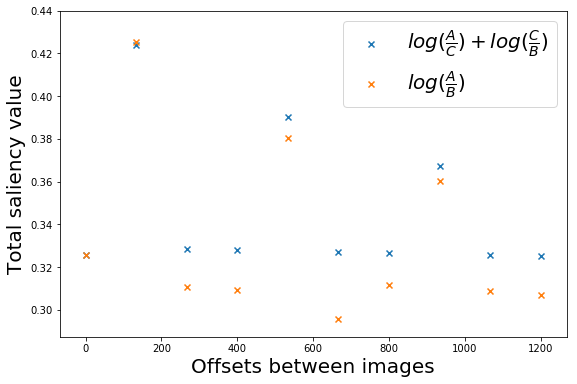

In [22]:
import matplotlib.pyplot as plt
offs = [k for k,v in d.iteritems()]
l = [v['left'] for k,v in d.iteritems()]
r = [v['right'] for k,v in d.iteritems()]

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.scatter(offs, r,label = r'$log(\frac{A}{C}) + log({\frac{C}{B}})$', marker = 'x')
plt.scatter(offs, l,  label = r'$log(\frac{A}{B})$',marker = 'x')
plt.xlabel('Offsets between images',size = '20')
plt.ylabel('Total saliency value',size = '20')
plt.legend(prop={'size':20})

#plt.subplot(1,2,2)
#plt.scatter(offs, np.array(r)-np.array(l), marker = 'x')
#plt.xlabel('Offsets between images',size = '20')
#plt.ylabel('Error', size = '20')
plt.savefig('/gpfs01/bethge/home/oeberle/Results/offset_influence_0_1200_10.png', dpi = 100)
plt.show()


In [10]:
d2 = {k:{} for k in offsets2}
for off_set in offsets2:
    im_gluedAB, center = glue_images_fix(imga, imgb, offset=off_set)
    log_densityAB = uniform_dg_model.log_density(stimulus=im_gluedAB)    
    
    im_gluedAC, center = glue_images_fix(imga, imgc, offset=off_set)
    log_densityAC = uniform_dg_model.log_density(stimulus=im_gluedAC)    
    
    im_gluedBC, center = glue_images_fix(imgb, imgc, offset=off_set)
    log_densityBC = uniform_dg_model.log_density(stimulus=im_gluedBC)    
    

    tAB_A, tAB_B = get_total_saliency(log_densityAB)
    tBC_B, tBC_C = get_total_saliency(log_densityBC)
    tAC_A, tAC_C = get_total_saliency(log_densityAC)
    d2[off_set]['left'] = (tAB_A/ tAB_B) 
    d2[off_set]['right'] = (tAC_A/ tAC_C) + (tBC_C/ tBC_B)

Included Layers ['conv5_1', 'relu5_1', 'relu5_2', 'conv5_3', 'relu5_4'] summed at relu2_1
(1, 64, 384, 1055)
(1, 64, 384, 1055)
(1, 64, 384, 1055)
(1, 64, 384, 1055)
(1, 64, 192, 528)
(1, 128, 192, 528)
(1, 128, 192, 528)
(1, 128, 192, 528)
(1, 128, 192, 528)
(1, 128, 96, 264)
(1, 256, 96, 264)
(1, 256, 96, 264)
(1, 256, 96, 264)
(1, 256, 96, 264)
(1, 256, 96, 264)
(1, 256, 96, 264)
(1, 256, 96, 264)
(1, 256, 96, 264)
(1, 256, 48, 132)
(1, 512, 48, 132)
(1, 512, 48, 132)
(1, 512, 48, 132)
(1, 512, 48, 132)
(1, 512, 48, 132)
(1, 512, 48, 132)
(1, 512, 48, 132)
(1, 512, 48, 132)
(1, 512, 24, 66)
(1, 512, 24, 66)
(1, 512, 24, 66)
(1, 512, 24, 66)
(1, 512, 24, 66)
(1, 512, 24, 66)
(1, 512, 24, 66)
(1, 512, 24, 66)
(1, 512, 24, 66)
(1, 512, 12, 33)
Setting seed to 23455
0.0 527.25
0.0 191.75
4 4
(768, 2112)
(768, 2110)
0.0 527.25
0.0 191.75
4 4
(768, 2112)
(768, 2110)
0.0 527.25
0.0 191.75
4 4
(768, 2112)
(768, 2110)
0.0 527.25
0.0 191.75
4 4
(768, 2112)
(768, 2110)
0.0 527.25
0.0 191.75
4 

/usr/local/lib/python2.7/dist-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
0.0 683.5
0.0 191.75
4 4
(768, 2736)
(768, 2735)
Included Layers ['co

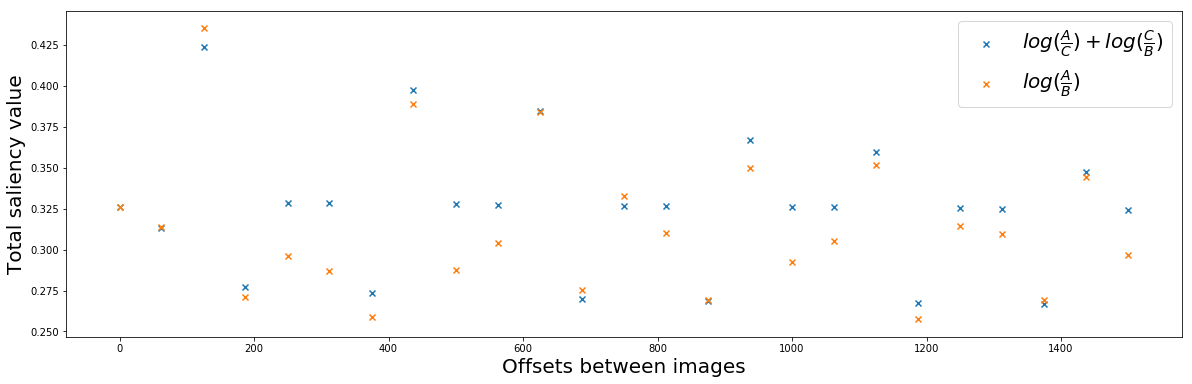

In [11]:
offs = [k for k,v in d2.iteritems()]
l = [v['left'] for k,v in d2.iteritems()]
r = [v['right'] for k,v in d2.iteritems()]

plt.figure(figsize=(20,6))
#plt.subplot(1,2,1)
plt.scatter(offs, r,label = r'$log(\frac{A}{C}) + log({\frac{C}{B}})$', marker = 'x')
plt.scatter(offs, l,  label = r'$log(\frac{A}{B})$',marker = 'x')
plt.xlabel('Offsets between images',size = '20')
plt.ylabel('Total saliency value',size = '20')
plt.legend(prop={'size':20})
plt.savefig('/gpfs01/bethge/home/oeberle/Results/offset_influence2.png', dpi = 100)
plt.show()


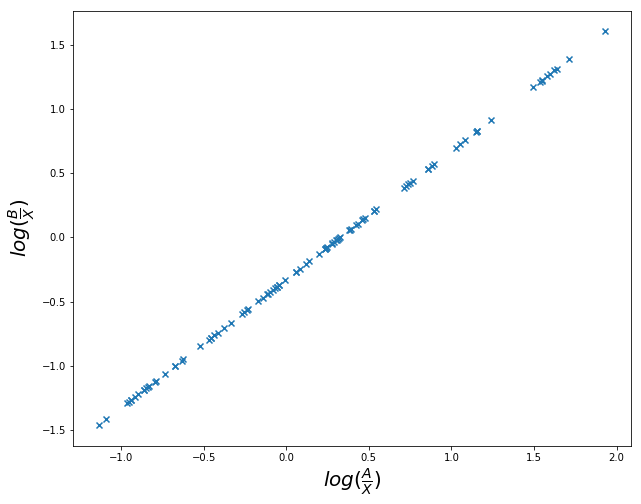

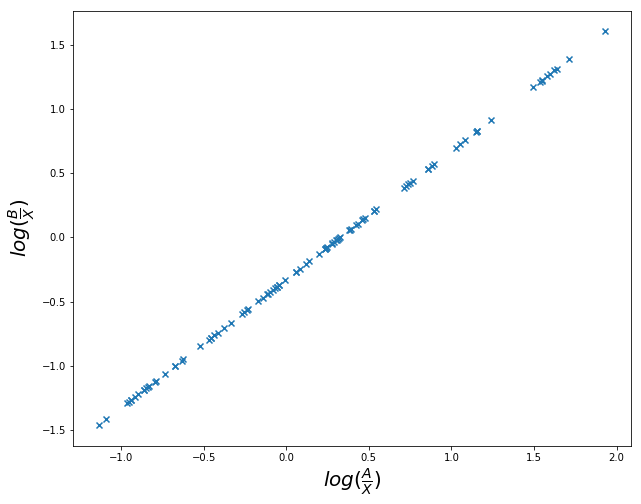

In [18]:
import cPickle as pickle
total_saliency_test = pickle.load(open('/gpfs01/bethge/home/oeberle/Results/total_saliency_onesize_log_scatter_test_2_100_image.pkl', 'rb'))

LL = []
for k,v in total_saliency_test.iteritems():
    l=[]
    for k,v in v.iteritems():
        l.append(v['log'])
    LL.append(l)
    
#plt.plot(LL[0], 'x')
#plt.plot(LL[1], c='r')
plt.figure(figsize=(10,8))
plt.scatter(LL[0],LL[1], marker = 'x')
plt.xlabel(r'$log(\frac{A}{X})$', size=20)
plt.ylabel(r'$log(\frac{B}{X})$', size=20)
plt.show()

## Create total saliency dict:

In [84]:
import glob
import cPickle as pickle
dicts = sorted(glob.glob("/gpfs01/bethge/home/oeberle/Results/total_saliency_uniform/*.pkl"))[:8]
#dicts.remove('/gpfs01/bethge/home/oeberle/Results/total_saliency_uniform/img_10.pkl')
print(dicts)
ts_dict = {}
for d in dicts:
    print(d)
    dic = pickle.load(open(d, 'rb'))
    ts_dict.update(dic)


[u'/gpfs01/bethge/home/oeberle/Results/total_saliency_uniform/img_0.pkl', u'/gpfs01/bethge/home/oeberle/Results/total_saliency_uniform/img_1.pkl', u'/gpfs01/bethge/home/oeberle/Results/total_saliency_uniform/img_10.pkl', u'/gpfs01/bethge/home/oeberle/Results/total_saliency_uniform/img_11.pkl', u'/gpfs01/bethge/home/oeberle/Results/total_saliency_uniform/img_12.pkl', u'/gpfs01/bethge/home/oeberle/Results/total_saliency_uniform/img_13.pkl', u'/gpfs01/bethge/home/oeberle/Results/total_saliency_uniform/img_14.pkl', u'/gpfs01/bethge/home/oeberle/Results/total_saliency_uniform/img_15.pkl']
/gpfs01/bethge/home/oeberle/Results/total_saliency_uniform/img_0.pkl
/gpfs01/bethge/home/oeberle/Results/total_saliency_uniform/img_1.pkl
/gpfs01/bethge/home/oeberle/Results/total_saliency_uniform/img_10.pkl
/gpfs01/bethge/home/oeberle/Results/total_saliency_uniform/img_11.pkl
/gpfs01/bethge/home/oeberle/Results/total_saliency_uniform/img_12.pkl
/gpfs01/bethge/home/oeberle/Results/total_saliency_uniform/im

## Total Variance vs. RGB variance

In [85]:
def get_stimulus_from_id(mit1003_stimuli, image_id):
    stimulus = mit1003_stimuli[mit1003_stimuli.stimulus_ids.index(image_id)]
    return stimulus
        
def get_RGB_std_from_id(mit1003_stimuli, image_id):
    image = get_stimulus_from_id(mit1003_stimuli, image_id)
    im = image.stimulus_data.flatten()/255.
    return np.std(im)

rgb_std = {}
for i_id in mit1003_stimuli.stimulus_ids:
    rgb_std[i_id] = get_RGB_std_from_id(mit1003_stimuli, i_id)
    
import cPickle as pickle
output = open('/gpfs01/bethge/home/oeberle/Results/RGB_std_dict.pkl', 'wb')
pickle.dump(rgb_std, output)
output.close()

In [30]:
rgb_std = pickle.load(open('/gpfs01/bethge/home/oeberle/Results/RGB_std_dict.pkl', 'rb'))

In [133]:

data = {k:{} for k in ts_dict.keys()}
for key,val in ts_dict.iteritems():
    duell_ts = np.array([v['total_saliency'] for k,v in val.iteritems()])
    duell_var = np.array([[rgb_std[key], rgb_std[k]] for k,_ in val.iteritems()])
    res_ts = duell_ts[:,0] >= duell_ts[:,1]
    res_var = duell_var[:,0] >= duell_var[:,1]
    explained = np.sum(res_ts == res_var)/len(res_ts)
    #print('Explained by Variance: {:.2%}, Total_Saliency: {:.2%}, Variance: {:.2%}'.format(explained, np.sum(res_ts)/len(res_ts), np.sum(res_var)/len(res_var)))
    
    data[key] = {'ts': duell_ts, 'std': duell_var, 'ids': [k for k,_ in val.iteritems()], 'duel': res_ts == res_var}
    print('Explained by Variance: {:.2%}'.format(explained))

Explained by Variance: 78.83%
Explained by Variance: 57.45%
Explained by Variance: 54.21%
Explained by Variance: 94.17%
Explained by Variance: 49.03%
Explained by Variance: 51.84%
Explained by Variance: 67.39%
Explained by Variance: 48.60%


In [106]:
hash_dict = {i:k for i,k in enumerate(val.keys())}
hash_dict_inv = {v:k for k,v in hash_dict.iteritems()}



In [16]:
import cPickle as pickle
if False:
    
    output = open('/gpfs01/bethge/home/oeberle/Results/Var_vs_TotSal_scatter/hash_dict_scatter.pkl', 'wb')
    pickle.dump(hash_dict, output)
    output.close()

    output = open('/gpfs01/bethge/home/oeberle/Results/Var_vs_TotSal_scatter/hash_dict_inv_scatter.pkl', 'wb')
    pickle.dump(hash_dict_inv, output)
    output.close()
if True:
    hash_dict = pickle.load(open('/gpfs01/bethge/home/oeberle/Results/Var_vs_TotSal_scatter/hash_dict_scatter.pkl', 'rb'))
    hash_dict_inv = pickle.load(open('/gpfs01/bethge/home/oeberle/Results/Var_vs_TotSal_scatter/hash_dict_inv_scatter.pkl', 'rb'))

In [121]:
from matplotlib import colors
import six

colors_ = list(six.iteritems(colors.cnames))
# Transform to hex color values.
hex_ = [color[1] for color in colors_]


In [ ]:
#plt.figure(figsize = (20,20))
c = 0
plt.figure(figsize = (15,24))
for id1,v in data.iteritems():
    ax = plt.subplot(4,2,c+1)
        # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    l1,l2 = 0, 0
    for duel, id2 in zip(v['duel'], v['ids']):
        idx2 = hash_dict_inv[id2]
        if duel == False:
            if l1 == 0:
                plt.scatter(np.log(v['ts'][idx2][0]/v['ts'][idx2][1]), np.log(v['std'][idx2][0]/ v['std'][idx2][1]), marker = 'x', color='r' , label = r'$\sigma_{RGB}$ wrong')
                l1 = 1
            if l1 == 1:
                plt.scatter(np.log(v['ts'][idx2][0]/v['ts'][idx2][1]), np.log(v['std'][idx2][0]/ v['std'][idx2][1]), marker = 'x', color='r' )#, label = r'$\sigma_{RGB}$ wrong')
        if duel == True:
            if l2 == 0:
                plt.scatter(np.log(v['ts'][idx2][0]/v['ts'][idx2][1]), np.log(v['std'][idx2][0]/ v['std'][idx2][1]), marker = 'x', color='g',label=   r'$\sigma_{RGB}$ correctly')
                l2 = 1
            if l2 == 1:
                plt.scatter(np.log(v['ts'][idx2][0]/v['ts'][idx2][1]), np.log(v['std'][idx2][0]/ v['std'][idx2][1]), marker = 'x', color='g') #,label=   r'$\sigma_{RGB}$ correctly')
           
        ax.annotate('{},{}'.format(hash_dict_inv[id1],idx2 ), (np.log(v['ts'][idx2][0]/v['ts'][idx2][1]), np.log(v['std'][idx2][0]/ v['std'][idx2][1])), fontsize=4)
    c = c + 1
    
    plt.xlabel('Total saliency log(A/B)',size= 14)
    if not c%2 == 0:
        plt.ylabel(r'RGB standard dev. $log(\frac{\sigma(A)}{\sigma(B)})$', size= 14)
    plt.title('Image {} vs 463 images, {:.2%}'.format(c, np.sum(v['duel'])/len(v['duel'])), size= 15)
    if c == 1:
        plt.legend()
plt.savefig('/gpfs01/bethge/home/oeberle/Results/Var_vs_TotSal_scatter/RGBvar_vs_totsal_scatter.png', dpi = 200)
plt.show()

## Extreme cases

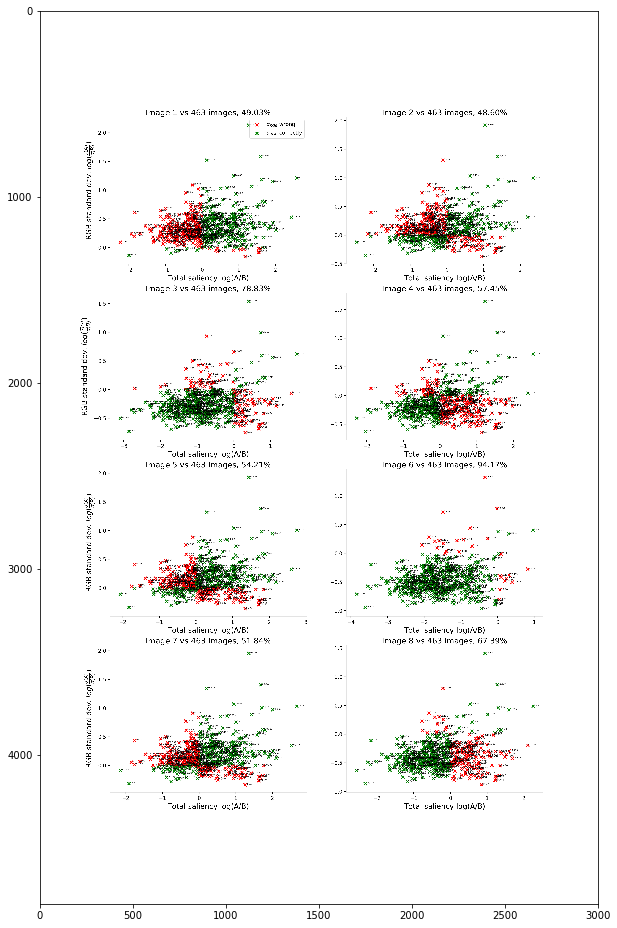

In [8]:
from scipy.ndimage import imread
import matplotlib.pyplot as plt
plt.figure(figsize=(10,20))
plt.imshow(imread('/gpfs01/bethge/home/oeberle/Results/Var_vs_TotSal_scatter/RGBvar_vs_totsal_scatter.png'))
plt.show()

0.0 767.75
0.0 191.75
4 4
(768, 3072)
(768, 3072)
0.0 767.75
0.0 191.75
4 4
(768, 3072)
(768, 3072)
0.0 767.75
0.0 191.75
4 4
(768, 3072)
(768, 3072)
0.0 767.75
0.0 191.75
4 4
(768, 3072)
(768, 3072)
0.0 767.75
0.0 191.75
4 4
(768, 3072)
(768, 3072)
0.0 767.75
0.0 191.75
4 4
(768, 3072)
(768, 3072)
0.0 767.75
0.0 191.75
4 4
(768, 3072)
(768, 3072)
0.0 767.75
0.0 191.75
4 4
(768, 3072)
(768, 3072)
0.0 767.75
0.0 191.75
4 4
(768, 3072)
(768, 3072)
0.0 767.75
0.0 191.75
4 4
(768, 3072)
(768, 3072)


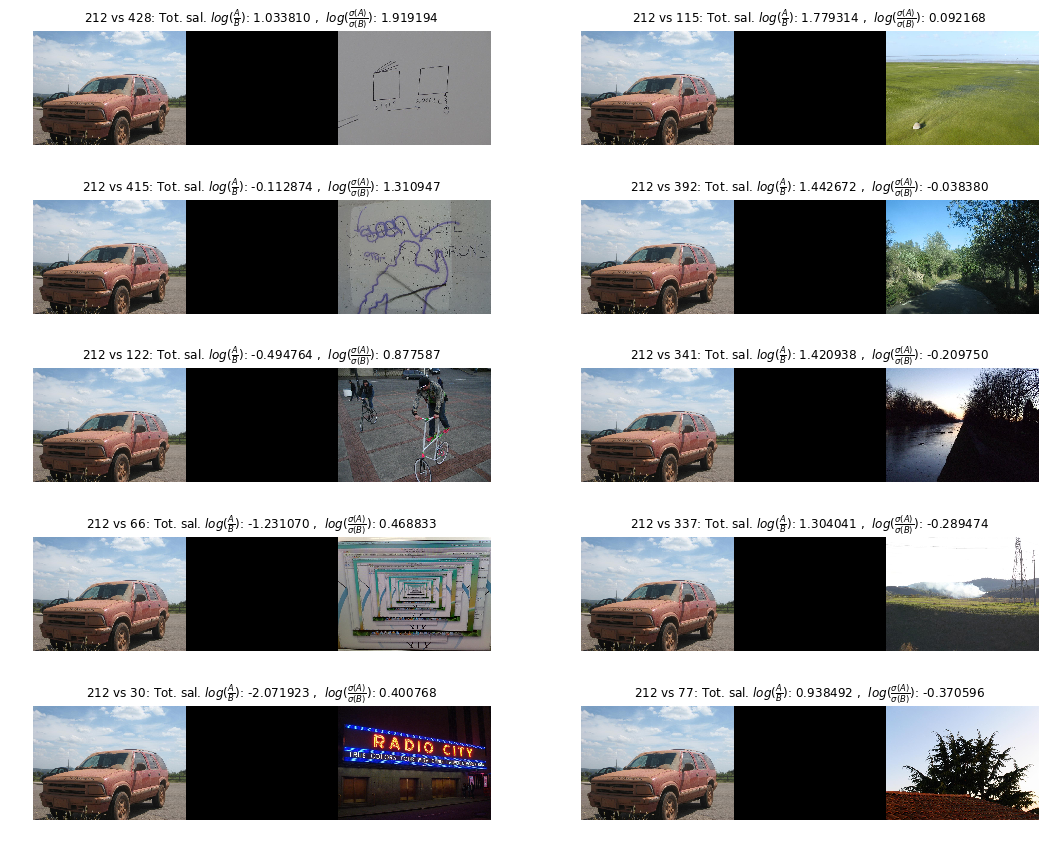

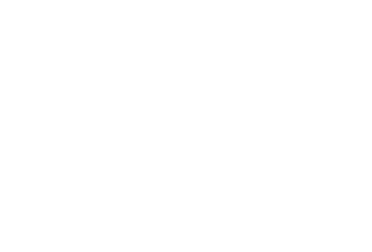

In [55]:
idx_of_interest = {'upper_left': [(212,428),(212,415), (212,122),(212,66),(212,30)], 
                   'lower_right': [(212,115),(212,392),(212,341), (212,337),(212,77),]}
myfig = plt.figure(figsize = (18,15))

def glue_and_get_saliency(im1, im2):
    im_glued,c = glue_images(im1, im2)
    log_density = uniform_dg_model.log_density(stimulus=im_glued)  
    tA, tB = get_total_saliency(log_density)
    return im_glued, tA, tB
def get_stimulus_from_id(mit1003_stimuli, image_id):
    stimulus = mit1003_stimuli[mit1003_stimuli.stimulus_ids.index(image_id)]
    return stimulus
        

i = 0
for k,v in idx_of_interest.iteritems():
    
    for i,t_idx in enumerate(v):
        
        if k == 'upper_left':
            plt.subplot(5,2,i*2 + 1)
        if k == 'lower_right':
            plt.subplot(5,2,i*2 + 2)   
        im1 = get_stimulus_from_id(mit1003_stimuli, hash_dict[t_idx[0]])
        im2 = get_stimulus_from_id(mit1003_stimuli,  hash_dict[t_idx[1]])
        rgb1 = rgb_std[hash_dict[t_idx[0]]]
        rgb2 = rgb_std[hash_dict[t_idx[1]]]
        im_glued, tA, tB = glue_and_get_saliency(im1.stimulus_data, im2.stimulus_data)
        plt.imshow(im_glued)
        plt.title(r'{} vs {}: Tot. sal. $log(\frac{{A}}{{B}})$: {:2f} ,  $log(\frac{{\sigma(A)}}{{\sigma(B)}})$: {:2f}'.format(t_idx[0], t_idx[1], np.log(tA/tB), np.log(rgb1/rgb2)), y=1.04)
        plt.axis('off')
plt.show()
SaveFigureAsImage('/gpfs01/bethge/home/oeberle/Results/Var_vs_TotSal_scatter/extreme_cases.png',  myfig)        



In [49]:
def SaveFigureAsImage(fileName,fig=None,**kwargs):
    ''' Save a Matplotlib figure as an image without borders or frames.
       Args:
            fileName (str): String that ends in .png etc.

            fig (Matplotlib figure instance): figure you want to save as the image
        Keyword Args:
            orig_size (tuple): width, height of the original image used to maintain 
            aspect ratio.
    '''
    fig_size = fig.get_size_inches()
    w,h = fig_size[0], fig_size[1]
    fig.patch.set_alpha(0)
    if kwargs.has_key('orig_size'): # Aspect ratio scaling if required
        w,h = kwargs['orig_size']
        w2,h2 = fig_size[0],fig_si#ze[1]
        fig.set_size_inches([(w2/w)*w,(w2/w)*h])
        fig.set_dpi((w2/w)*fig.get_dpi())
    a=fig.gca()
    a.set_frame_on(False)
    a.set_xticks([]); a.set_yticks([])
    plt.axis('off')
    plt.xlim(0,h); plt.ylim(w,0)
    fig.savefig(fileName, transparent=True, bbox_inches='tight', \
                        pad_inches=0)#, dpi = 120)


In [4]:
def get_image_from_dataset(img_base, n_im):
    im = img_base.stimulus_data
    
    

## Get images from database and converse

In [ ]:
def get_image_data():
    